# Mice data exercise

Perform the following filtering analysis:

- **1. Missingness and filtering, both at the variant- and individual-level.**
- **2. Minor Allele Frequency filtering.**
- **3. Hardy-Weinberg Equilibrium.**
- **4. Heterozygosity rate.**


In [1]:
ln -sf ../../Data
ln -sf ../Results

# **1. Filtering excessive missing values.** 

First of all, we begin by producing the sample-wise and variant-wise missing reports in the format `.imiss` and `.lmiss`. Note that sex will not be considered at all by PLINK as mentioned in the warning.

In [3]:
plink --bfile Data/mice --allow-no-sex --missing --out Results/GWAS3/mice --silent

<img src="../Images/R.png" alt="R" width="40">  Switch to the R-GWAS kernel.
 
Now we look at the histograms. The only thing needed to change in the code, compared to the tutorial, is the name of the two missingness reports.

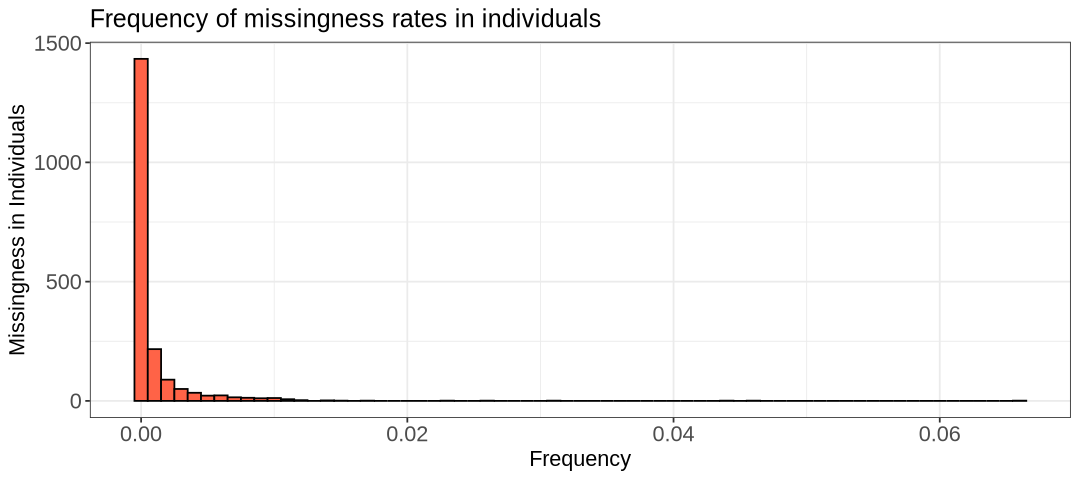

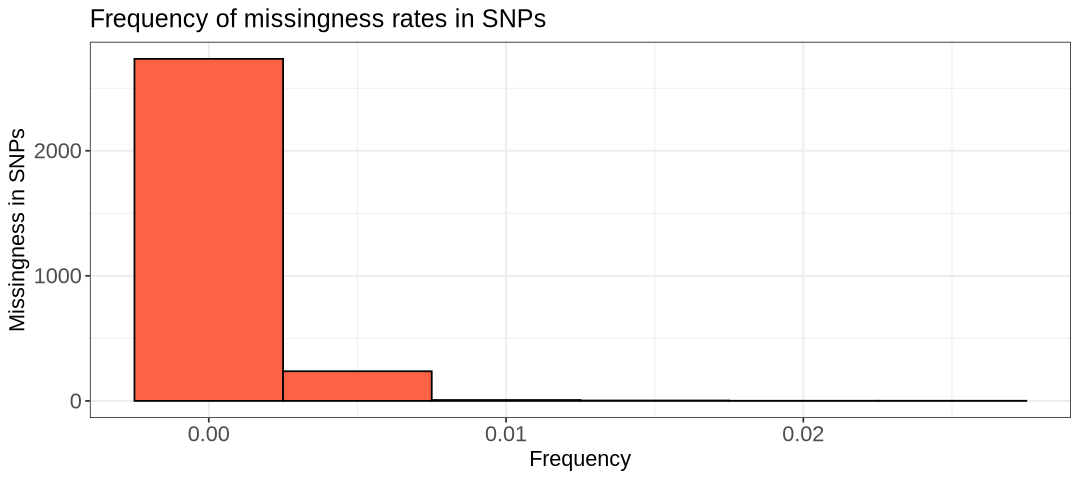

In [2]:
library(ggplot2)
options(repr.plot.width = 9, repr.plot.height = 4)

# Read data into R 
indmiss <- read.table(file="Results/GWAS3/mice.imiss", header=TRUE)
snpmiss <- read.table(file="Results/GWAS3/mice.lmiss", header=TRUE)

#imiss histogram
hist.imiss <- ggplot(indmiss, aes(x=indmiss[,6])) +
  geom_histogram(binwidth = 0.001, col = "black", fill="tomato") + 
  labs(title = "Frequency of missingness rates in individuals") + 
  xlab("Frequency") + 
  ylab("Missingness in Individuals") + 
  theme_bw()+
  theme(axis.title=element_text(size=13), axis.text=element_text(size=13), plot.title=element_text(size=15))

#lmiss histogram
hist.lmiss <- ggplot(snpmiss, aes(x=snpmiss[,5])) +
  geom_histogram(binwidth = 0.005, col = "black", fill="tomato") + 
  labs(title = "Frequency of missingness rates in SNPs") + 
  xlab("Frequency") + 
  ylab("Missingness in SNPs") + 
  theme_bw()+
  theme(axis.title=element_text(size=13), axis.text=element_text(size=13), plot.title=element_text(size=15))

#show histograms
show(hist.imiss)
show(hist.lmiss)

The histograms do not show any high missingness for the variants (second plot), while there are a few individuals that we should filter out. Below, we filter only individuals with missingness above 2%, without choosing any variant filter. The new `bed, bim, fam` files have the prefix `mice_miss`

In [4]:
plink --bfile Data/mice --mind .02 --allow-no-sex --make-bed --out Results/GWAS3/mice_miss --silent

# **2. Minimum Allele Frequency**. 
Let's calculate the MAF values using `--freq`: 

In [5]:
# Generate a plot of the MAF distribution.
plink --bfile Results/GWAS3/mice_miss --freq --out Results/GWAS3/mice_miss --silent

<img src="../Images/R.png" alt="R" width="40">  Switch to the R-GWAS kernel.

Let's plot the MAF histogram using `R`. The second plot, is a zoom-in version with MAF up to 0.1 to observe the low MAF values. 

Warning message:
“Removed 2611 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


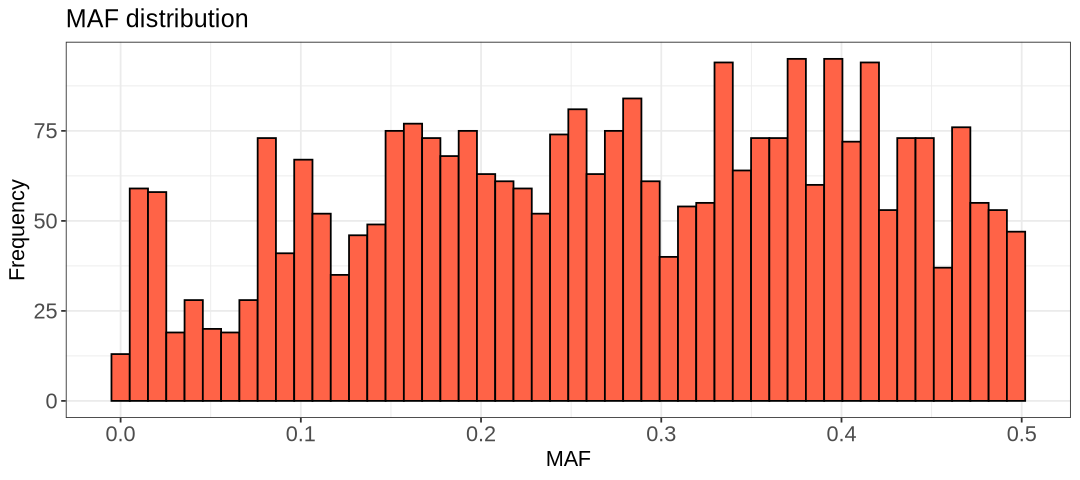

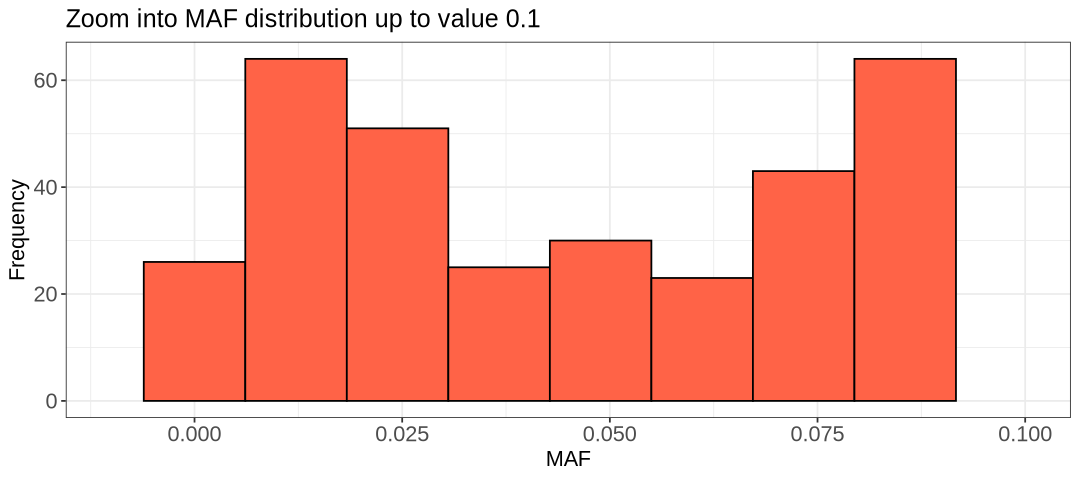

In [3]:
#| label: fig-MAF
#| fig-cap: "MAF plot for the autosomal SNPs only. Note the zoomed interval (0, 0.1)"

library(ggplot2)
options(repr.plot.width = 9, repr.plot.height = 4)

# Read data into R 
maf_freq <- read.table("Results/GWAS3/mice_miss.frq", header =TRUE, as.is=T)

# maf_freq histogram
hist.maf <- ggplot(maf_freq, aes(x=maf_freq[,5])) +
  geom_histogram(col = "black", fill="tomato", bins=50) + 
  labs(title = "MAF distribution") + 
  xlab("MAF") + 
  ylab("Frequency") +
  theme_bw()+
  theme(axis.title=element_text(size=13), axis.text=element_text(size=13), plot.title=element_text(size=15))

# zoom-in into X-axis
hist.maf.zoom <- ggplot(maf_freq, aes(x=maf_freq[,5])) +
  geom_histogram(col = "black", fill="tomato", bins = 10) + 
  labs(title = "Zoom into MAF distribution up to value 0.1") + 
  xlab("MAF") + 
  ylab("Frequency") +
  xlim(-.01, 0.1) +
  theme_bw()+
  theme(axis.title=element_text(size=13), axis.text=element_text(size=13), plot.title=element_text(size=15))


show(hist.maf)
show(hist.maf.zoom)

There are two minor peaks in the histograms above, one at 0.05 and 0.1. Choosing 0.1 would remove over a hundred extra SNPs, while 0.05 should remove around less than 200. We can for example choose 0.05, but 0.1 is acceptable as well as it is another threshold often applied in literature.

In [6]:
# Remove SNPs with a low MAF frequency.
plink --bfile Results/GWAS3/mice_miss --maf 0.05 --make-bed --out Results/GWAS3/mice_miss_maf --silent

# **3. Hardy Weinberg Equilibrium**. 

Here we need again to apply the option `hardy` to calculate observed and expected heterozigous frequencies and p-values for the binomial test. Note how column `TEST` considers all individuals ( `ALL(NP)` stands for `ALL Not Pruned`).

In [7]:
plink --bfile Results/GWAS3/mice_miss_maf --hardy --out Results/GWAS3/mice_miss_maf --silent

awk '{ if ($9 <0.00001) print $0 }' Results/GWAS3/mice_miss_maf.hwe > Results/GWAS3/mice_miss_maf.deviating.hwe

In [8]:
head Results/GWAS3/mice_miss_maf.hwe 

 CHR                  SNP     TEST   A1   A2                 GENO   O(HET)   E(HET)            P 
   1            rs3683945  ALL(NP)    A    G         358/1002/572   0.5186   0.4939      0.03035
   1            rs3707673  ALL(NP)    G    A         359/1003/572   0.5186   0.4939      0.03048
   1            rs6269442  ALL(NP)    A    G          252/887/791   0.4596    0.461       0.8824
   1            rs6336442  ALL(NP)    A    G         358/1003/572   0.5189   0.4939      0.02714
   1           rs13475700  ALL(NP)    A    C          33/442/1458   0.2287   0.2283            1
   1            rs3658242  ALL(NP)    A    T         359/1003/572   0.5186   0.4939      0.03048
   1           rs13475701  ALL(NP)    C    G          33/481/1417   0.2491   0.2432       0.3045
   1            rs6198069  ALL(NP)    A    G          186/802/945   0.4149   0.4229       0.4197
   1            rs3659303  ALL(NP)    A    G         360/1001/571   0.5181    0.494      0.03419


In [9]:
wc -l Results/GWAS3/mice_miss_maf.deviating.hwe

356 Results/GWAS3/mice_miss_maf.deviating.hwe


There are 355 variants to remove with a p-value below 0.00001

<img src="../Images/R.png" alt="R" width="40">  Switch to the R-GWAS kernel.

Now we create histograms to look at the p-values from the tables above. We do not need to use the case-control renaming and plotting categories.

In [2]:
suppressMessages(suppressWarnings(library(dplyr)))

# Read data into R using dplyr library 
hwe <- read.table(file="Results/GWAS3/mice_miss_maf.hwe", header=TRUE)
hwe_zoom <- read.table(file="Results/GWAS3/mice_miss_maf.deviating.hwe", header=FALSE)
colnames(hwe_zoom) <- colnames(hwe)

Here, we print the first rows of the two generated tables

In [3]:
#| label: fig-HWEtables
#| fig-cap: "HWE tables from PLINK"

head(hwe)
head(hwe_zoom)

,CHR,SNP,TEST,A1,A2,GENO,O.HET.,E.HET.,P
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,1,rs3683945,ALL(NP),A,G,358/1002/572,0.5186,0.4939,0.03035
2,1,rs3707673,ALL(NP),G,A,359/1003/572,0.5186,0.4939,0.03048
3,1,rs6269442,ALL(NP),A,G,252/887/791,0.4596,0.4610,0.88240
4,1,rs6336442,ALL(NP),A,G,358/1003/572,0.5189,0.4939,0.02714
5,1,rs13475700,ALL(NP),A,C,33/442/1458,0.2287,0.2283,1.00000
6,1,rs3658242,ALL(NP),A,T,359/1003/572,0.5186,0.4939,0.03048


[1] "ALL(NP)"

,CHR,SNP,TEST,A1,A2,GENO,O.HET.,E.HET.,P
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,1,rs13475729,ALL(NP),G,A,46/339/1549,0.1753,0.1980,3.014e-06
2,1,rs13475730,ALL(NP),G,A,46/339/1547,0.1755,0.1982,3.079e-06
3,1,rs3654377,ALL(NP),G,A,46/339/1549,0.1753,0.1980,3.014e-06
4,1,rs3655978,ALL(NP),A,G,46/339/1545,0.1756,0.1984,3.146e-06
5,1,rs13475731,ALL(NP),A,G,46/339/1548,0.1754,0.1981,3.046e-06
6,1,rs3670630,ALL(NP),A,C,46/339/1545,0.1756,0.1984,3.146e-06


Now, we can plot the histograms

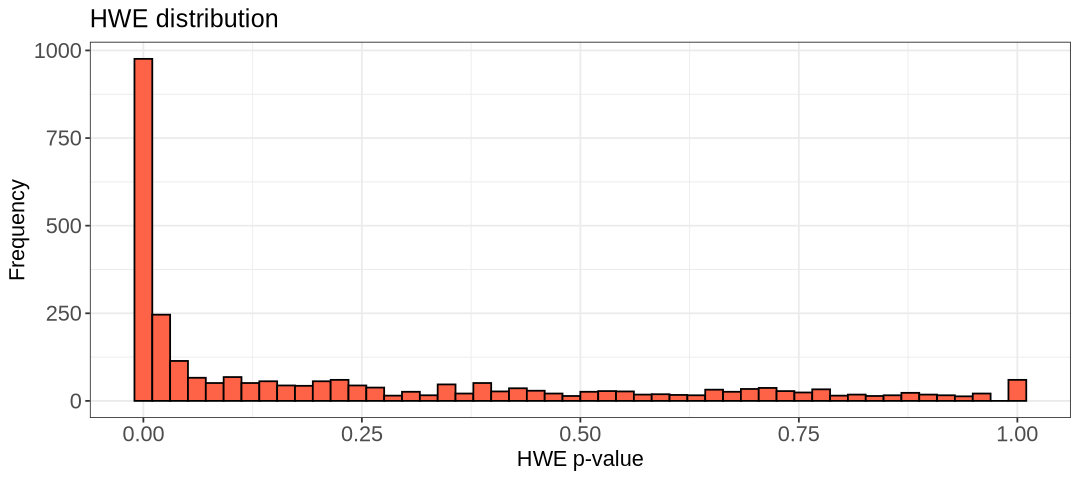

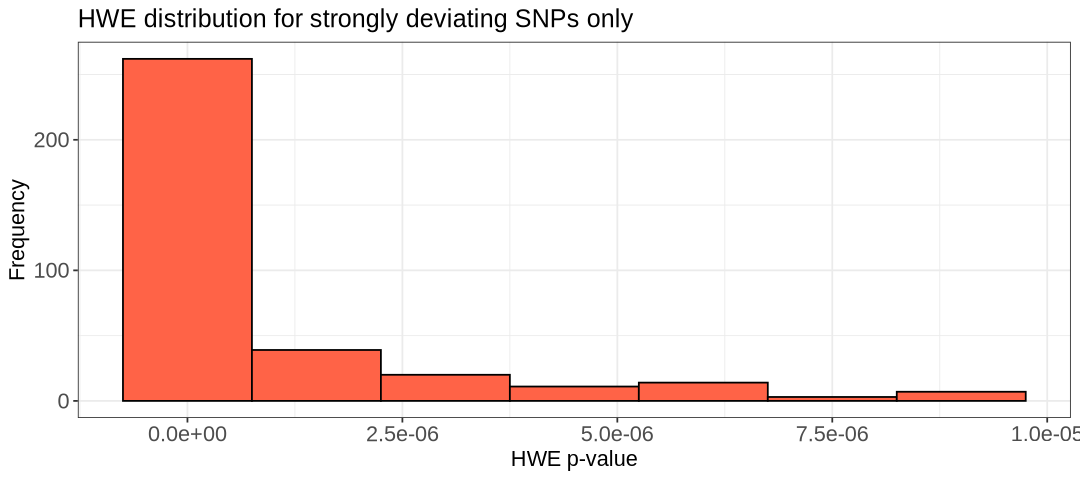

In [6]:
#| label: fig-HWE
#| fig-cap: "HWE p-values calculated with PLINK and zoom for the SNPs deviating from HWE."
suppressMessages(suppressWarnings(library(ggplot2)))
options(repr.plot.width = 9, repr.plot.height = 4)

# maf_freq histogram
hist.hwe <- ggplot(hwe, aes(x=hwe[,9])) +
  geom_histogram(col = "black", fill="tomato", bins=50) + 
  labs(title = "HWE distribution") + 
  xlab("HWE p-value") + 
  ylab("Frequency") +
  theme_bw()+
  theme(axis.title=element_text(size=13), axis.text=element_text(size=13), plot.title=element_text(size=15))

# maf_freq histogram
hist.hwe_below_threshold <- ggplot(hwe_zoom, aes(x=hwe_zoom[,9])) +
  geom_histogram(binwidth = 0.0000015, col = "black", fill="tomato") + 
  labs(title = "HWE distribution for strongly deviating SNPs only") + 
  xlab("HWE p-value") + 
  ylab("Frequency") +
  theme_bw()+
  theme(axis.title=element_text(size=13), axis.text=element_text(size=13), plot.title=element_text(size=15))

show(hist.hwe)
show(hist.hwe_below_threshold)

We choose the threshold 1e-5 and create the new filtered data files:

In [1]:
plink --bfile Results/GWAS3/mice_miss_maf --hwe 1e-5 --make-bed --out Results/GWAS3/mice_miss_maf_hwe --silent

# **4. Heterozigosity rate.** 
Now we look at genotype calls at each individual's level. First, we create a list of SNPs for which there is lower correlation, so to avoid linkage disequilibrium.

In [2]:
plink --bfile Results/GWAS3/mice_miss_maf_hwe --indep-pairwise 50 5 0.2 --out Results/GWAS3/mice_indepSNP --silent

With this pruned list, we measure the heterozygosity rates of the individuals in the remaining independent SNPs.

In [3]:
plink --bfile Results/GWAS3/mice_miss_maf_hwe --extract Results/GWAS3/mice_indepSNP.prune.in --het --out Results/GWAS3/mice_R_check --silent

How does the table with the SNPs look like?

In [4]:
head -5 Results/GWAS3/mice_R_check.het

         FID          IID       O(HOM)       E(HOM)        N(NM)            F
  A048005080   A048005080          112        109.5          184      0.03357
  A048006063   A048006063          111        109.5          184      0.02015
  A048006555   A048006555          105        109.5          184     -0.06039
  A048007096   A048007096           94        109.5          184       -0.208


<img src="../Images/R.png" alt="R" width="40">  Switch to the R-GWAS kernel.

We are going to calculate by hand the heterozygosity rates so we can plot them (not by default in the table). The formula for the rates is $N(NM)-O(HOM)/N(NM)$

In [ ]:
#| label: fig-HET
#| fig-cap: "Barplot of heterozigosity rates."

library(ggplot2)
options(repr.plot.width = 9, repr.plot.height = 4)

het <- read.table("Results/GWAS3/mice_R_check.het", head=TRUE)

het$HET_RATE = (het$"N.NM." - het$"O.HOM.")/het$"N.NM."

# plink.imiss histogram
hist.het <- ggplot(het, aes(x=HET_RATE)) +
  geom_histogram(binwidth = 0.01, col = "black", fill="tomato") + 
  labs(title = "Heterozygosity Rates") + 
  xlab("Heterozygosity Rate") + 
  ylab("Frequency") + 
  theme_bw()


show(hist.het)

We use the same filter for all individuals as applied to the other dataset (heterozigosity rate 3 standard deviations away from the mean)

In [2]:
suppressMessages(suppressWarnings(library(dplyr)))

het <- read.table("Results/GWAS3/mice_R_check.het", head=TRUE)
het$HET_RATE = (het$"N.NM." - het$"O.HOM.")/het$"N.NM."

het_fail <- subset(het, (het$HET_RATE < mean(het$HET_RATE)-3*sd(het$HET_RATE)) | 
                    (het$HET_RATE > mean(het$HET_RATE)+3*sd(het$HET_RATE)))

het_fail$HET_DST <- (het_fail$HET_RATE-mean(het$HET_RATE))/sd(het$HET_RATE);

write.table(het_fail, "Results/GWAS3/mice-fail-het-qc.txt", row.names=FALSE, quote=FALSE)

The resulting table contains a few outlying individuals:

In [1]:
wc -l Results/GWAS3/mice-fail-het-qc.txt

9 Results/GWAS3/mice-fail-het-qc.txt


We use `awk` to print out the first two columns in the file `het-fail-ind.txt` and use the option `--remove` to filter out the individuals with PLINK.

In [2]:
awk '{print$1, $2}' Results/GWAS3/mice-fail-het-qc.txt > Results/GWAS3/mice-het-fail-ind.txt

plink --bfile Results/GWAS3/mice_miss_maf_hwe --remove Results/GWAS3/mice-het-fail-ind.txt --make-bed --out Results/GWAS3/mice_QCA --silent

What are we left with? 1926 samples with 2439 variants

In [3]:
wc -l Results/GWAS3/mice_QCA.fam
wc -l Results/GWAS3/mice_QCA.bim

1926 Results/GWAS3/mice_QCA.fam
2439 Results/GWAS3/mice_QCA.bim
